## Please set the Data Directory `DATA_DIR` below to a folder with
1) Dataset_description.docx
2) Dataset_model.csv
3) subjects_questions.csv
4) Submit.csv

In [1]:
DATA_DIR = './data'

import os
import os.path as osp
import pandas as pd
import numpy as np


import os
for f in ['Dataset_model.csv','subjects_questions.csv','Submit.csv']:
    if not osp.isfile(osp.join(DATA_DIR,f)):
        raise ValueError(f"Please put all CSVs into {DATA_DIR}. Did not find {f}")
print("All good!")

All good!


## Load Dataframe

In [2]:
VALIDATION_ROW = 100
student_cols_str = ['city', 'country', 'device', 'device_type', 'os',
       'platform', 'region', 'gp_carrers', 'gp_college type',
       'gp_degree course', 'gp_previous experience', 'gp_school type',
       'gp_segment', 'gp_source_project']
student_cols_int = ['novo_user_id']
student_cols = student_cols_int + student_cols_str 
# List columns related to questions
question_cols_int = ['novo_question_id','commented_by_professor', 'difficulty', 'discipline_id',
       'examining_board_id', 'institute_id', 'knowledge_area_id',
       'modality_id', 'nullified', 'outdated', 'product_id',
       'publication_year', 'scholarity_id']
question_cols_str =  ['right_answer']
question_cols = question_cols_int + question_cols_str
interaction_cols =['novo_user_id','novo_question_id','created_at','row', 'acertou']
dtype_dct = {}
for k in student_cols_str + question_cols_str + ['created_at']:
    dtype_dct[k] = 'string'
for k in student_cols_int + question_cols_int + ['row','acertou']:
    dtype_dct[k] = 'int32'

df = pd.read_csv(osp.join(DATA_DIR,'Dataset_model.csv'),dtype={k:'string' for k in student_cols_str})
df = pd.concat([df,pd.read_csv(osp.join(DATA_DIR,'Submit.csv'),sep=';') ],axis=0,ignore_index=True)
df = df.sort_values(['novo_user_id','row'])
df.columns = [c.replace(':','_') for c in df.columns]

/tmp/ipykernel_28543/3914382153.py:22: DtypeWarning: Columns (9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(osp.join(DATA_DIR,'Dataset_model.csv'),dtype={k:'string' for k in student_cols_str})


### Fill NA values

In [3]:
df_x = df.loc[:,['nullified','right_answer','acertou']]
b = (df['row'] < 101)
display(
    pd.DataFrame.from_dict({k:pd.isna(df.loc[b,k]).mean() for k in df.columns},orient='index',columns=['0']).sort_values(['0'])
)
from pandas.api.types import is_numeric_dtype
for c in df.columns:
    if is_numeric_dtype(df[c]):
        df[c] = df[c].fillna(-1)
    else:
        df[c] = df[c].fillna('unk')


,0
novo_user_id,0.000000
row,0.000000
created_at,0.000000
acertou,0.000000
novo_question_id,0.000000
knowledge_area_id,0.000089
discipline_id,0.000089
commented_by_professor,0.000089
scholarity_id,0.000089
modality_id,0.000089


## Separate dataframe into train, val, test

In [4]:
def separate_label(df):
    y=df['acertou']
    x=df.drop(['acertou'],axis = 1)
    return x, y

def get_dataset(df, mode):
    assert VALIDATION_ROW < 101
    if mode == 'train':
        b = (df.row < VALIDATION_ROW).values & (False == pd.isna(df.acertou)).values
    elif mode == 'val':
        b = (df.row <= VALIDATION_ROW).values & (False == pd.isna(df.acertou)).values
    elif mode == 'test':
        b = (df.row == df.row)
    else:
        raise ''
    
    return separate_label(df.loc[b,:])

X = {k: get_dataset(df,k)[0] for k in ['train','val','test']}
Y = {k: get_dataset(df,k)[1] for k in ['train','val','test']}



def create_embeddings(df):
    X = df.copy()
    s_emb = X.loc[:,student_cols].copy()
    # Create question embeddings
    q_emb_cols = list(question_cols)
    q_emb_cols.remove('novo_question_id')
    
    q_emb = X.loc[:,q_emb_cols].copy()
    for c in q_emb.columns:
        if q_emb[c].dtype == 'object':
            q_emb[c] = q_emb[c].astype('category').cat.codes
        q_emb[c] = q_emb[c].astype('int64')
        q_emb[c] -= q_emb[c].min()
        

    # Create student embeddings
    s_emb_cols = list(student_cols)
    s_emb_cols.remove('novo_user_id')
    s_emb = X.loc[:,s_emb_cols].copy()
    for c in s_emb.columns:
        if s_emb[c].dtype == 'object':
            s_emb[c] = s_emb[c].astype('category').cat.codes
        s_emb[c] = s_emb[c].astype('int64')
        s_emb[c] -= s_emb[c].min()
    
    return q_emb, s_emb

q_emb, s_emb = create_embeddings(df)
q_emb_maxs = [q_emb[c].max() for c in q_emb.columns]
s_emb_maxs = [s_emb[c].max() for c in s_emb.columns]

q_emb = {k: q_emb.loc[X[k].index,:] for k in ['train','val','test']}
s_emb = {k: s_emb.loc[X[k].index,:] for k in ['train','val','test']}




In [11]:
print([q_emb[k].shape for k in ['train','val','test']])

[(1980000, 13), (2000000, 13), (2020000, 13)]


## Pytorch Dataset

In [5]:
import torch
from tqdm import tqdm, trange

from torch.utils.data import Dataset, DataLoader
DEVICE = 'cuda'

class QDataset(Dataset):
    
    def __init__(self, X, q_emb, s_emb, Y,mode):
        super(Dataset,self).__init__()
        self.mode = mode
        self.X = X
        self.Y = torch.tensor(Y.values, dtype=torch.int64, device=DEVICE)
        self.q_emb = torch.tensor(q_emb.values, dtype=torch.int64, device=DEVICE)
        self.s_emb = torch.tensor(s_emb.values, dtype=torch.int64, device=DEVICE)
        
        self.idx_map = sorted([(g,np.array(df2.index) ) for g, df2 in X.reset_index().groupby('novo_user_id') ] )
        self.idx_map = dict([(i,v) for i, (k,v) in enumerate(self.idx_map) ])

    
    def __getitem__(self, idx):
        idx = self.idx_map[idx]
        if self.mode == 'train':
            beg = np.random.randint(idx.shape[0])
            idx = np.concatenate([idx, idx])
            end = (beg + 50)
            beg, end = min(beg, end), max(beg, end)
            idx = idx[beg:end]
            #idx = idx[np.random.permutation(idx.shape[0])]
        #self.X.iloc[idx,:]
        return self.q_emb[idx,:], self.s_emb[idx,:], self.Y[idx]
    
    def __len__(self):
        return len(self.idx_map.keys())
        
ds = {k:QDataset(X[k], q_emb[k], s_emb[k], Y[k], k) for k in ['train','val','test']}
dl = {k: DataLoader(ds[k], batch_size=32) for k in ['train','val', 'test']}
for q, s, y in tqdm(dl['train'], total=len(dl['train'])):
    pass

100%|████████████████████████████████████████| 625/625 [00:01<00:00, 426.47it/s]


## Define and Train model. If the variable   ``IS_CHECKING`` is set to ``True``, then we load the `pred.pt` weights into the model and create a prediction dataframe using it.

/home/klaus/anaconda3/envs/ldm/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 174.22it/s]


0.73123187
0.84425


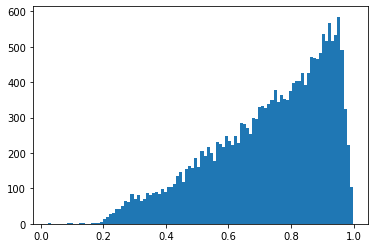

EPOCH 0 (train)
{'loss': 0.6569649, 'thresh': 0.521374, 'f1_score': 0.8076304143757543}
val


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 203.89it/s]


0.7353739
0.8975


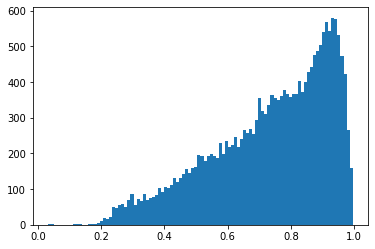

EPOCH 0 (val)
{'loss': 0.6479886, 'thresh': 0.4602074, 'f1_score': 0.8144501278772378}
test


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 206.87it/s]


0.73489296
0.89965


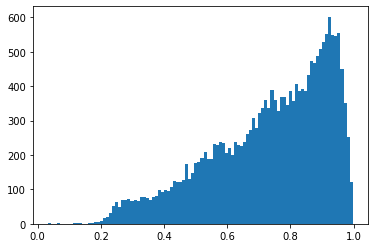

,preds,probas
0,1,0.679859
1,1,0.954152
2,1,0.633662
3,1,0.943785
4,0,0.369755
...,...,...
19995,1,0.871123
19996,1,0.630238
19997,1,0.749827
19998,1,0.783042


In [13]:
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.s_embs =\
        nn.ModuleList([nn.Embedding(num_embeddings=1+s_emb_maxs[i],
                                   embedding_dim = min(s_emb_maxs[i]+1, 16)).to(DEVICE) 
                                   for i in range(len(s_emb_maxs))])
        self.q_embs =\
                nn.ModuleList([nn.Embedding(num_embeddings=1+q_emb_maxs[i],
                                           embedding_dim = min(q_emb_maxs[i]+1, 32)).to(DEVICE) 
                                           for i in range(len(q_emb_maxs))])
        self.lstm = nn.Sequential(nn.LazyLinear(128),
                                  nn.LeakyReLU(),
                                  nn.LazyLinear(128),
                                  nn.LSTM(input_size = 128, hidden_size = 128))
        
        self.mlp_q =   nn.Sequential(nn.Dropout(0.5),nn.LazyLinear(32))
        self.mlp_s =   nn.Sequential(nn.Dropout(0.5),nn.LazyLinear(32))
        
        self.mlp = nn.Sequential(nn.LazyLinear(64), nn.LeakyReLU(), nn.LazyLinear(1))
        
        
    def __call__(self, q, s, y):
        batch_size, num_steps, q_attrs = q.shape
        _, _, s_attrs = s.shape

        y_lag = y.clone() 
        y_lag[:,-1] = 0
        y_lag[:,1:] = y[:,:-1]
        y_lag = y_lag.reshape(batch_size * num_steps, 1)
        y_lag = 2*y_lag - 1
        # Reshape
        q = q.reshape(batch_size * num_steps, -1) # (B*T, a_q)
        s = s.reshape(batch_size * num_steps, -1)# (B*T, a_s)
        
        # Get the embeddings
        Q = torch.cat([self.q_embs[i](q[:,i]) for i in range(q_attrs)],dim=-1) # 
        S = torch.cat([self.s_embs[i](s[:,i]) for i in range(s_attrs)],dim=-1)
        
        
        # reshape back
        Q = Q.reshape(batch_size, num_steps, -1).transpose(0,1)
        S = S.reshape(batch_size, num_steps, -1).transpose(0,1)
        
        y_lag = y_lag.reshape(batch_size, num_steps, 1).transpose(0,1).float()
        """
        Q = self.mlp_q(Q.reshape(batch_size * num_steps, -1)).reshape(batch_size, num_steps, -1)
        S = self.mlp_s(S.reshape(batch_size * num_steps, -1)).reshape(batch_size, num_steps, -1)
        h_n = (Q*S).mean(1)
        """
        E  = torch.cat([y_lag,S, Q], dim=-1)
        # shuffle
        #idx = torch.randperm(E.shape[0])
        #E = E[idx,:,:]
        #E = E[-50:,:,:]
        
        out, (h_n, c_n) = self.lstm(E)
        out = self.mlp(h_n).reshape(-1)
        return out

def find_best_thresh(targets, probas):
    from sklearn.metrics import precision_recall_curve, f1_score
    precision, recall, thresholds = precision_recall_curve(targets,probas)
    thresholds = list(thresholds) + [1]
    f1_scores = 2*recall*precision/(recall+precision+1e-10)
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)
    return best_thresh, best_f1

def apply_best_thresh(targets, probas, thresh):
    from sklearn.metrics import precision_recall_curve, f1_score
    pred = (probas >= thresh).astype(np.int32)
    return pred, f1_score(targets.clip(0,1), pred)


IS_CHECKING = True

model = MyModel().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr= 1e-4)
num_epochs = 3000
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1/0.65).to(DEVICE), reduction='none')
best_thresh = -1
best_f1 = 0
dl = {k: DataLoader(ds[k], batch_size=64, shuffle=(k=='train')) for k in ['train','val', 'test']}
writer = SummaryWriter()
model.load_state_dict(torch.load('./pred.pt'))
for epoch in range(num_epochs):
    if epoch == 1 and IS_CHECKING:
        break
    for mode in ['train','val', 'test']:
        print(mode)
        stat_dct = {'loss': []}
        
        all_probas = []
        all_targets = []
        first = True
        with torch.set_grad_enabled(mode == 'train' and not IS_CHECKING):
            for q, s, y in tqdm(dl[mode], total=len(dl[mode])):

                logits = model(q,s,y)
                target = y[:,-1].float()
                bce = criterion(logits, target)
                loss = bce.mean()
                
                all_targets.append(target.long().cpu().numpy())
                all_probas.append(torch.sigmoid(logits).detach().cpu().numpy())
                stat_dct['loss'].append(loss.detach().cpu().numpy().reshape(-1,1))
                
                if mode == 'train' and not IS_CHECKING:
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
        
        
        
        stat_dct = {k: np.concatenate(v, -1).mean() for k,v in stat_dct.items()}
        # Calculate f1 score stuff
        all_targets = np.concatenate([x.reshape(-1) for x in all_targets])
        all_probas = np.concatenate([x.reshape(-1) for x in all_probas])
        if mode in ['train','val']: 
            best_thresh, _ = find_best_thresh(all_targets, all_probas)
        all_preds, f1_score = apply_best_thresh(all_targets, all_probas, thresh=best_thresh)
        stat_dct['thresh'] = best_thresh
        stat_dct['f1_score'] = f1_score
        
        
        if IS_CHECKING:
            print(all_probas.mean())
            print(all_preds.mean())
            plt.hist(all_probas,bins=100)
            plt.show()
            
        
        if best_f1 < f1_score and mode == 'val':
            best_f1 = f1_score
            if not IS_CHECKING:
                torch.save(model.state_dict(),'./best_nov12.pt')
                pred_df = pd.DataFrame({'preds':all_preds, 'probas':all_probas})
                pred_df['preds'].to_csv('Nov12.csv',header=None,index=None)
                print("New Best")
        if mode == 'test':
            pred_df = pd.DataFrame({'preds':all_preds, 'probas':all_probas})
            display(pred_df)
            break
        for k,v in stat_dct.items():
            writer.add_scalar(f'{k}/{mode}', v, epoch)
        
        print('======================')
        print(f"EPOCH {epoch} ({mode})")
        print(stat_dct)
        
                    
            
            
    
    

# Compare with submitted prediction

In [14]:
pred_submitted = pd.read_csv('./pred_submitted.csv', header = None)
pred_df['submitted'] = pred_submitted.iloc[:,0].values
display(pred_df)
err = np.sum(np.square(pred_df['preds'].values - pred_df['submitted'].values))

print(f"Soma de erros quadraticos entre predicao enviada e verificada é {err}")
print(pred_df.loc[pred_df['preds'] == 1,'probas'].min())

print(pred_df.loc[pred_df['submitted'] == 1,'probas'].min())
print(20000-pred_df['submitted'].sum())
print(20000-pred_df['preds'].sum())


,preds,probas,submitted
0,1,0.679859,1
1,1,0.954152,1
2,1,0.633662,1
3,1,0.943785,1
4,0,0.369755,0
...,...,...,...
19995,1,0.871123,1
19996,1,0.630238,1
19997,1,0.749827,1
19998,1,0.783042,1


Soma de erros quadraticos entre predicao enviada e verificada é 0
0.46029443
0.46029443
2007
2007
